# Brain Tumor Segmentation  Unet

**Import Libraries** 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model, load_model
from keras.layers import Input ,BatchNormalization , Activation 
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers 
from sklearn.model_selection import train_test_split
import os
import nibabel as nib
import cv2 as cv
import matplotlib.pyplot as plt
from keras import backend as K
import glob
import skimage.io as io
import skimage.color as color
import random as r
import math
from nilearn import plotting
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
Flair= nib.load('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_flair.nii')
Seg= nib.load('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_seg.nii')
T1= nib.load('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t1.nii')
T1ce= nib.load('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t1ce.nii')
T2= nib.load('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t2.nii')

**Fluid-attenuated inversion recovery (FLAIR) :**

**FLAIR is an MRI sequence with an inversion recovery set to null fluids. For example, it can be used in brain imaging to suppress cerebrospinal fluid (CSF) effects on the image, so as to bring out the periventricular hyperintense lesions, such as multiple sclerosis (MS) plaques**

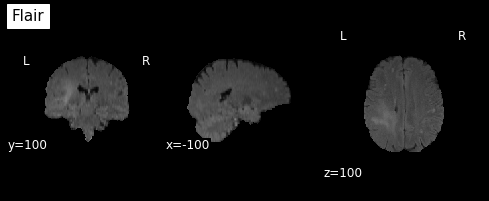

In [3]:
plotting.plot_anat(Flair,cut_coords=[-100, 100, 100],title="Flair",draw_cross =False)

**Manual segmentation that annotated by an expert**

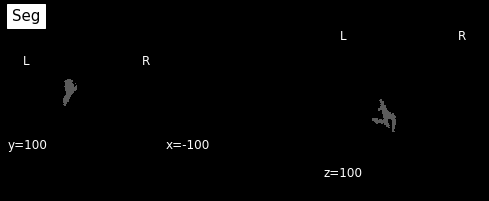

In [4]:
plotting.plot_anat(Seg,cut_coords=[-100, 100, 100],title="Seg",draw_cross =False)

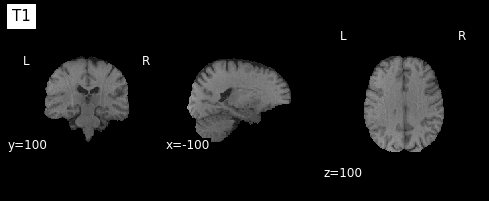

In [5]:
plotting.plot_anat(T1,cut_coords=[-100, 100, 100],title="T1",draw_cross =False)

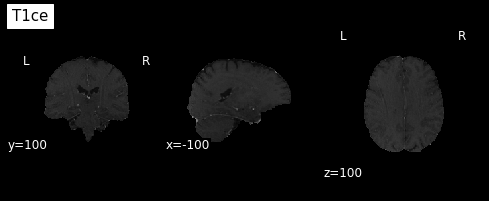

In [6]:
plotting.plot_anat(T1ce,cut_coords=[-100, 100, 100],title="T1ce",draw_cross =False)

**T2 weighted image :**


**T2 weighted image (T2WI) is one of the basic pulse sequences in MRI. The sequence weighting highlights differences in the T2 relaxation time of tissues.**

**The amount of T2 decay a tissue experiences depends on multiple factors. Each tissue has an inherent T2 value, but external factors (such as magnetic field inhomogeneity) can decrease the T2 relaxation time. This additional effect is captured in T2*. The refocusing pulse in spin-echo sequences helps to mitigate these extraneous influences on the T2 relaxation time, trying to keep the image T2 weighted rather than T2* weighted.**

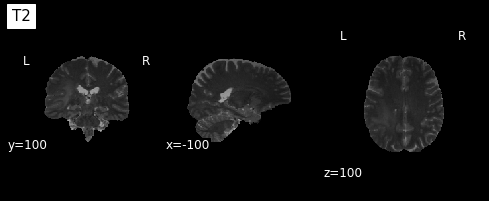

In [7]:
plotting.plot_anat(T2,cut_coords=[-100, 100, 100],title="T2",draw_cross =False)

# Data Preprocessing

In [13]:
Path= '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
p=os.listdir(Path)
Input_Data= []
def Data_Preprocessing(modalities_dir):
    all_modalities = []    
    for modality in modalities_dir:      
        nifti_file   = nib.load(modality)
        brain_numpy  = np.asarray(nifti_file.dataobj)    
        all_modalities.append(brain_numpy)
    brain_affine   = nifti_file.affine
    all_modalities = np.array(all_modalities)
    all_modalities = np.rint(all_modalities).astype(np.int16)
    all_modalities = all_modalities[:, :, :, :]
    all_modalities = np.transpose(all_modalities)
    return all_modalities
for i in p[:200]:
    brain_dir = os.path.normpath(Path+'/'+i)
    flair     = glob.glob(os.path.join(brain_dir, '*_flair*.nii'))
    t1        = glob.glob(os.path.join(brain_dir, '*_t1*.nii'))
    t1ce      = glob.glob(os.path.join(brain_dir, '*_t1ce*.nii'))
    t2        = glob.glob(os.path.join(brain_dir, '*_t2*.nii'))
    gt        = glob.glob( os.path.join(brain_dir, '*_seg*.nii'))
    modalities_dir = [flair[0], t1[0], t1ce[0], t2[0], gt[0]]
    P_Data = Data_Preprocessing(modalities_dir)
    Input_Data.append(P_Data)


**Check the output**

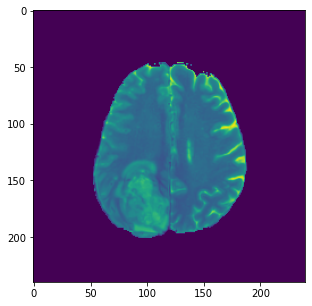

In [5]:
fig = plt.figure(figsize=(5,5))
immmg = Input_Data[1][100,:,:,3]
imgplot = plt.imshow(immmg)
plt.show()

**concatenate images**

In [9]:
def Data_Concatenate(Input_Data):
    counter=0
    Output= []
    for i in range(5):
        print('$')
        c=0
        counter=0
        for ii in range(len(Input_Data)):
            if (counter != len(Input_Data)):
                a= Input_Data[counter][:,:,:,i]
                #print('a={}'.format(a.shape))
                b= Input_Data[counter+1][:,:,:,i]
                #print('b={}'.format(b.shape))
                if(counter==0):
                    c= np.concatenate((a, b), axis=0)
                    print('c1={}'.format(c.shape))
                    counter= counter+2
                else:
                    c1= np.concatenate((a, b), axis=0)
                    c= np.concatenate((c, c1), axis=0)
                    print('c2={}'.format(c.shape))
                    counter= counter+2
        c= c[:,:,:,np.newaxis]
        Output.append(c)
    return Output

In [11]:
InData= Data_Concatenate(Input_Data)

$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)


In [13]:
AIO= concatenate(InData, axis=3)
AIO=np.array(AIO,dtype='float32')
TR=np.array(AIO[:,:,:,1],dtype='float32')
TRL=np.array(AIO[:,:,:,4],dtype='float32')

In [14]:
X_train , X_test, Y_train, Y_test = train_test_split(TR, TRL, test_size=0.15, random_state=32)
AIO=TRL=0

**Implement Unet**

![Unet](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [15]:
def Convolution(input_tensor,filters):
    
    x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    return x

def model(input_shape):
    
    inputs = Input((input_shape))
    
    conv_1 = Convolution(inputs,32)
    maxp_1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_1)
    
    conv_2 = Convolution(maxp_1,64)
    maxp_2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_2)
    
    conv_3 = Convolution(maxp_2,128)
    maxp_3 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_3)
    
    conv_4 = Convolution(maxp_3,256)
    maxp_4 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_4)
    
    conv_5 = Convolution(maxp_4,512)
    upsample_6 = UpSampling2D((2, 2)) (conv_5)
    
    conv_6 = Convolution(upsample_6,256)
    upsample_7 = UpSampling2D((2, 2)) (conv_6)
    
    upsample_7 = concatenate([upsample_7, conv_3])
    
    conv_7 = Convolution(upsample_7,128)
    upsample_8 = UpSampling2D((2, 2)) (conv_7)
    
    conv_8 = Convolution(upsample_8,64)
    upsample_9 = UpSampling2D((2, 2)) (conv_8)
    
    upsample_9 = concatenate([upsample_9, conv_1])
    
    conv_9 = Convolution(upsample_9,32)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv_9)
    
    model = Model(inputs=[inputs], outputs=[outputs]) 
    
    return model

In [16]:
# Loding the Light weighted CNN
model = model(input_shape = (240,240,1))
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 240, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 240, 240, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 240, 240, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [17]:
# Computing Dice_Coefficient
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [18]:
# Compiling the model 
Adam=optimizers.Adam(lr=0.001)
model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy',dice_coef,precision,sensitivity,specificity])

In [19]:
# Fitting the model over the data
history = model.fit(X_train,Y_train,batch_size=32,epochs=40,validation_split=0.20,verbose=1,initial_epoch=0)

Epoch 1/40
66/66 [==============================] - 15s 233ms/step - loss: 0.2571 - accuracy: 0.9560 - dice_coef: 0.0892 - precision: 88.6587 - sensitivity: 0.7363 - specificity: 0.9669 - val_loss: 0.2453 - val_accuracy: 0.9745 - val_dice_coef: 0.0692 - val_precision: 0.5391 - val_sensitivity: 0.6180 - val_specificity: 0.9852
Epoch 2/40
66/66 [==============================] - 13s 202ms/step - loss: 0.1204 - accuracy: 0.9844 - dice_coef: 0.1410 - precision: 2755909120.0000 - sensitivity: 0.5886 - specificity: 0.9954 - val_loss: 0.1243 - val_accuracy: 0.9875 - val_dice_coef: 0.1317 - val_precision: 3.2189 - val_sensitivity: 0.6634 - val_specificity: 0.9975
Epoch 3/40
66/66 [==============================] - 13s 202ms/step - loss: 0.0890 - accuracy: 0.9777 - dice_coef: 0.2143 - precision: 1.4296 - sensitivity: 0.6405 - specificity: 0.9879 - val_loss: 0.0740 - val_accuracy: 0.9805 - val_dice_coef: 0.2480 - val_precision: 0.5135 - val_sensitivity: 0.7428 - val_specificity: 0.9899
Epoch 4/4

In [20]:
# Evaluating the model on the training and testing data 
model.evaluate(x=X_train, y=Y_train, batch_size=32 , verbose=1, sample_weight=None, steps=None)
model.evaluate(x=X_test, y=Y_test, batch_size=32, verbose=1, sample_weight=None, steps=None)

15/15 [==============================] - 1s 81ms/step - loss: -0.1772 - accuracy: 0.9910 - dice_coef: 1.3043 - precision: 0.9194 - sensitivity: 0.9669 - specificity: 0.9991


[-0.17720085382461548,
 0.9910366535186768,
 1.3043478727340698,
 0.9193868041038513,
 0.9669124484062195,
 0.9990680813789368]

In [22]:
# Accuracy vs Epoch
def Accuracy_Graph(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    #plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
    
# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):

    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    #plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
# Loss vs Epoch
def Loss_Graph(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

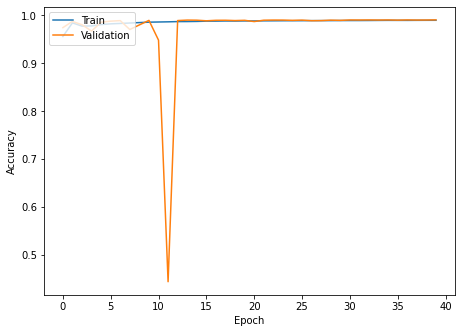

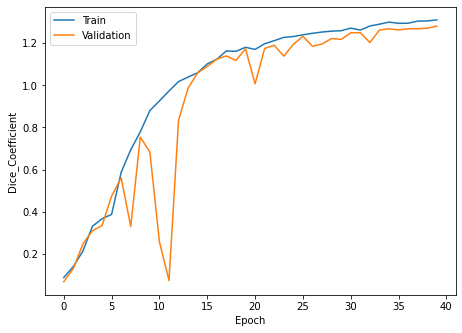

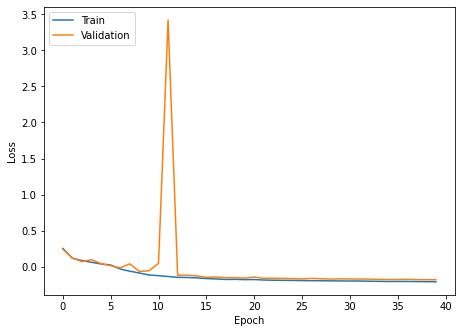

In [23]:
# Plotting the Graphs of Accuracy, Dice_coefficient, Loss at each epoch on Training and Testing data
Accuracy_Graph(history)
Dice_coefficient_Graph(history)
Loss_Graph(history)

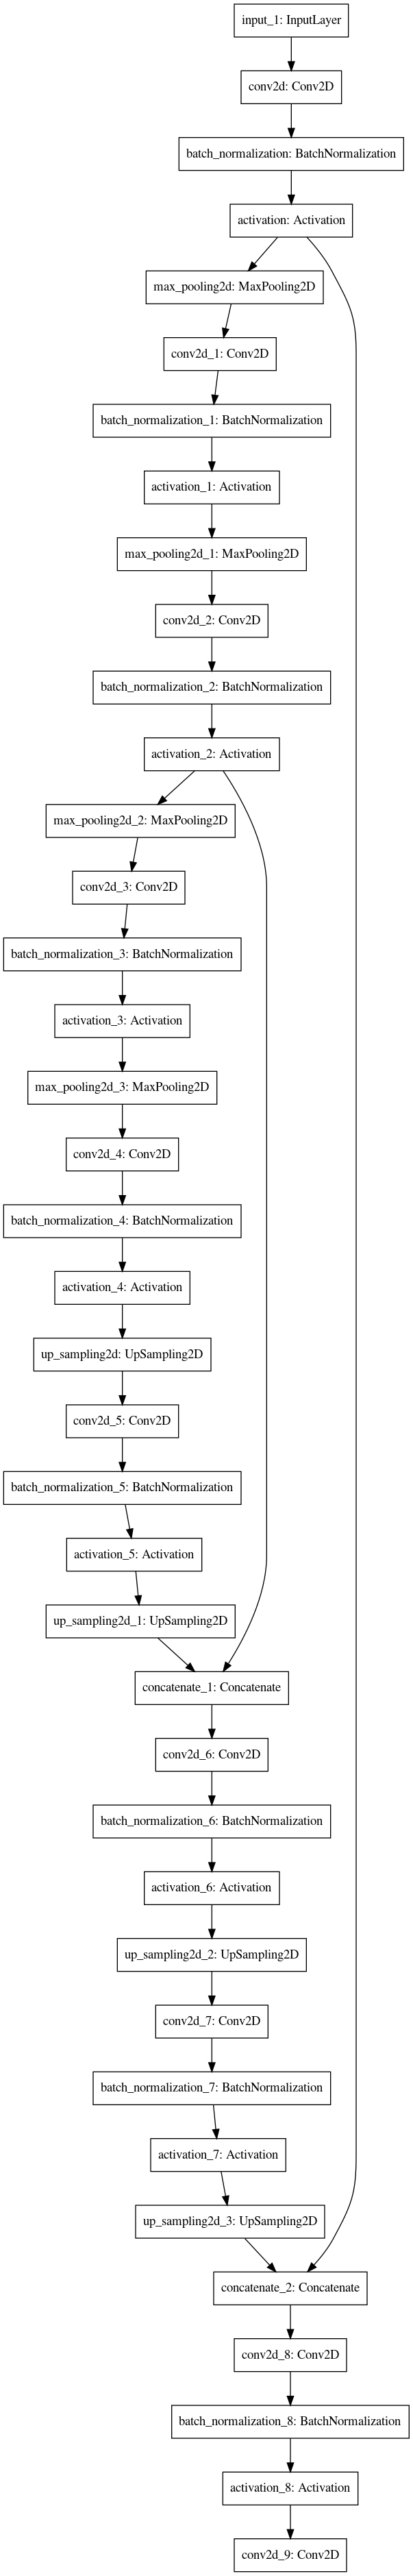

In [24]:
from keras.utils import plot_model
plot_model(model,to_file='model.png')

In [ ]:
model.save('./BraTs2020.h5')

In [26]:
model.load_weights('./BraTs2020.h5')

In [27]:
X_train=X_test=Y_train=Y_test=0

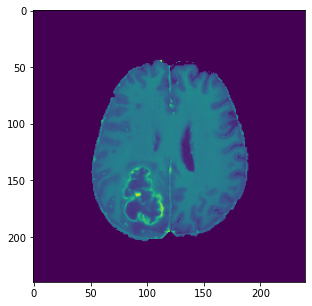

In [28]:
fig = plt.figure(figsize=(5,5))
immmg = TR[250,:,:]
imgplot = plt.imshow(immmg)
plt.show()

In [29]:
pref_Tumor = model.predict(TR)

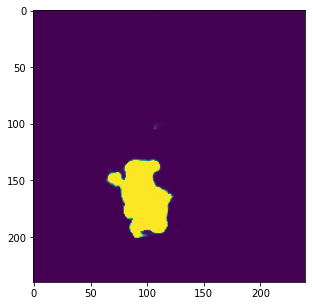

In [30]:
fig = plt.figure(figsize=(5,5))
immmg = pref_Tumor[250,:,:,0]
imgplot = plt.imshow(immmg)
plt.show()

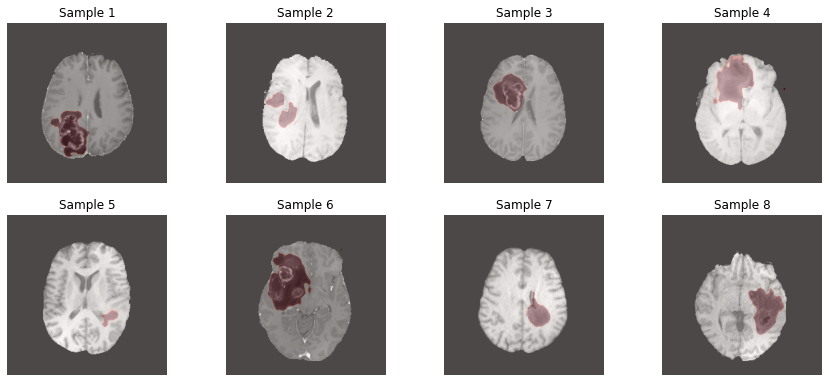

In [31]:
plt.figure(figsize=(15,10))


plt.subplot(341)
plt.title('Sample 1')
plt.axis('off')
plt.imshow(np.squeeze(TR[250,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[250,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(342)
plt.title('Sample 2')
plt.axis('off')
plt.imshow(np.squeeze(TR[550,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[550,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(343)
plt.title('Sample 3')
plt.axis('off')
plt.imshow(np.squeeze(TR[400,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[400,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(344)
plt.title('Sample 4')
plt.axis('off')
plt.imshow(np.squeeze(TR[690,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[690,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(345)
plt.title('Sample 5')
plt.axis('off')
plt.imshow(np.squeeze(TR[850,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[850,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(346)
plt.title('Sample 6')
plt.axis('off')
plt.imshow(np.squeeze(TR[1450,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[1450,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(347)
plt.title('Sample 7')
plt.axis('off')
plt.imshow(np.squeeze(TR[1800,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[1800,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(348)
plt.title('Sample 8')
plt.axis('off')
plt.imshow(np.squeeze(TR[60,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[60,:,:]),alpha=0.3,cmap='Reds')